In [1]:
import torch
import torchvision 
from torchvision import datasets, transforms
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import math
import os
import PIL
from torch import nn
import torch.nn.functional as F
import PIL.Image
from PIL import Image
import torchvision.utils as vutils

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from torchvision import transforms
import matplotlib.pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from IPython.display import display


In [2]:
   
def set_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)
            
        if isinstance(m, (nn.ConvTranspose2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)
            
        if isinstance(m, (nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)
            
class Gen(nn.Module):
    def __init__(self, channels=3, genZ=100, filters=32):
        super(Gen, self).__init__()
        self.channels = channels
        self.z = genZ
        self.filters = filters
        self.model = nn.Sequential(
            nn.ConvTranspose2d( self.z, self.filters * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(self.filters * 4),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(self.filters * 4, self.filters * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.filters * 2),
            nn.ReLU(True),
            
            nn.ConvTranspose2d( self.filters * 2, self.filters , 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.filters),
            nn.ReLU(True),
            
            nn.ConvTranspose2d( self.filters, self.channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.model(input)
    
    
class Disc(nn.Module):
    def __init__(self, channels=3,filters=32):
        super(Disc, self).__init__()
        self.channels = channels
        self.filters = filters
        self.model = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(self.channels, self.filters, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf) x 32 x 32
            nn.Conv2d(self.filters, self.filters * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.filters * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(self.filters * 2, self.filters * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.filters * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(self.filters * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.model(input)

Disc Loss:  1.2354351 Gen Loss:  0.7334544


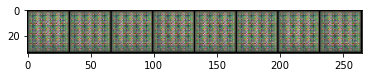

Disc Loss:  0.74328196 Gen Loss:  1.1300741


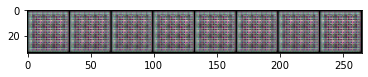

Disc Loss:  0.31952873 Gen Loss:  1.8693295


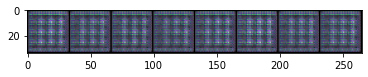

Disc Loss:  0.13681336 Gen Loss:  2.672721


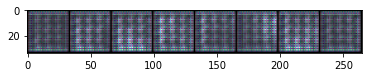

Disc Loss:  0.07436405 Gen Loss:  3.2853756


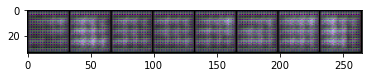

Disc Loss:  0.045380853 Gen Loss:  3.797872


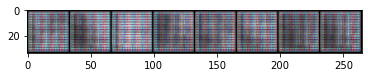

Disc Loss:  0.04167182 Gen Loss:  4.045514


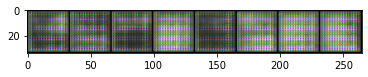

Disc Loss:  0.024594612 Gen Loss:  4.4054384


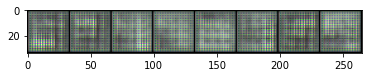

Disc Loss:  0.13143602 Gen Loss:  4.072118


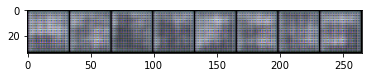

Disc Loss:  0.14632805 Gen Loss:  3.339988


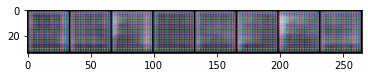

Disc Loss:  0.081245676 Gen Loss:  4.217128


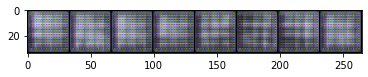

Disc Loss:  0.09498085 Gen Loss:  4.3611336


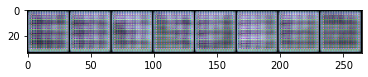

Disc Loss:  0.15172407 Gen Loss:  4.2235184


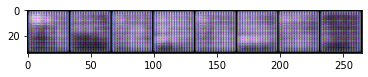

Disc Loss:  0.07243739 Gen Loss:  4.6505647


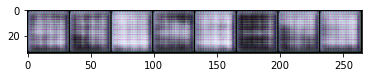

Disc Loss:  0.43245703 Gen Loss:  3.1700804


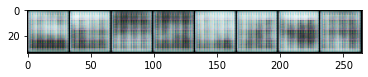

In [18]:
netG = Gen().to(device)
netG.apply(set_weights)


netD = Disc().to(device)
netD.apply(set_weights)

dataset = torchvision.datasets.ImageFolder(root='new/',
                           transform=transforms.Compose([
                               transforms.ToTensor()
                           ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True, num_workers=2)

loss = nn.BCELoss()
optimG = torch.optim.Adam(netG.parameters(), lr=0.0002)
optimD = torch.optim.Adam(netD.parameters(), lr=0.0002)



for epochs in range(15):
    d_err = []
    g_err = []
    for i, data in enumerate(dataloader):
        # In PyTorch, for every mini-batch during the training phase,
        # we typically want to explicitly set the gradients to zero before starting to do
        # backpropragation (i.e., updating the Weights and biases)
        netD.zero_grad()
        real_imgs , elp = data
#         print(real_imgs.size())
        real_imgs = real_imgs.to(device)
        real_labels = torch.ones(real_imgs.shape[0], device=device)
        real_labels = real_labels.unsqueeze(1)
        out = netD(real_imgs)
        out = out.view(-1,1) 
#         print(out.shape , target.size())
        real_img_err = loss(out , real_labels)
    
    
        noise = torch.randn(real_imgs.shape[0] , 100 , 1, 1)
        fake_imgs = netG(noise)
        fake_label = (torch.zeros(real_imgs.shape[0], device=device)).unsqueeze(1)
        out_ = netD(fake_imgs).view(-1,1)
        fake_img_err = loss(out_ , fake_label)
        
        disc_total_err = real_img_err + fake_img_err
        d_err.append(disc_total_err.detach().numpy())
        
        disc_total_err.backward(retain_graph=True)
        optimD.step()
        
        
        netG.zero_grad()
        real_label = torch.ones(real_imgs.shape[0], device=device)
        real_label = real_label.unsqueeze(1)
        out_fake = netD(fake_imgs)
        gen_err = loss (out_fake.view(-1,1) , real_label)
        g_err.append(gen_err.detach().numpy())
        
        gen_err.backward(retain_graph=True)
        optimG.step()
    torch.save(netD, 'model_d.pth')
    torch.save(netG, 'model_g.pth')
    print("Disc Loss: " , np.mean(d_err) , "Gen Loss: " , np.mean(g_err))
    plt.imshow(np.transpose(vutils.make_grid(fake_imgs.to(device), padding=1, normalize=True).cpu(),(1,2,0)))
    plt.show()



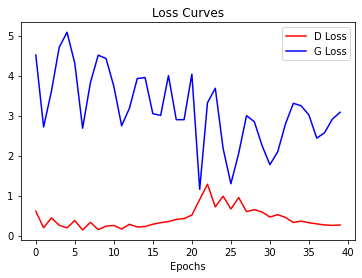

In [19]:
plt.plot(d_err, 'r' , label = "D Loss") # plotting t, a separately 
plt.plot(g_err, 'b' , label = "G Loss") # plotting t, b separately 
plt.xlabel("Epochs")
plt.title('Loss Curves')
plt.legend()
plt.show()

# plt.plot(vl, 'r' , label = "Loss") # plotting t, a separately 
# plt.plot(va, 'b' , label = "Accuracy") # plotting t, b separately 
# plt.xlabel("Epochs")
# plt.title('Loss and Accuracy Curves of Validation Data')
# plt.legend()
# plt.show()  

In [11]:
print_filters = True
if (print_filters==True):
    m = torch.load('model_d.pth')
    print(m)
    f = m.model[8].weight.detach().clone()
    n,c,w,h = f.shape
    f = f.view(n*c, -1, w, h)
    print("Discriminator's Last Layer's Filters Size:" , m.model[8].weight.detach().clone().size())
    f = f - f.min()
    f = f / f.max()
    filter_img = torchvision.utils.make_grid(f, nrow = 32 , normalize=True, padding=1)
    plt.figure( figsize=(500, 500) )
    print(f.shape)
    print(filter_img.numpy().transpose((1, 2, 0)).shape)
    plt.imshow(filter_img.numpy().transpose((1, 2, 0)))
    plt.show()

Disc(
  (model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(128, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (9): Sigmoid()
  )
)
Discriminator's Last Layer's Filters Size: torch.Size([1, 128, 4, 4])
torch.Size([128, 1, 4, 4])
(21, 161, 3)


In [14]:
print_filters = True
if (print_filters==True):
    m = torch.load('model_g.pth')
    print(m)
    f = m.model[9].weight.detach().clone()
    n,c,w,h = f.shape
    f = f.view(n*c, -1, w, h)
    print("Generator's Last Layer's Filters Size:" , m.model[9].weight.detach().clone().size())
    f = f - f.min()
    f = f / f.max()
    filter_img = torchvision.utils.make_grid(f, nrow = 32 , normalize=True, padding=1)
    plt.figure( figsize=(500, 500) )
    print(f.shape)
    print(filter_img.numpy().transpose((1, 2, 0)).shape)
    plt.imshow(filter_img.numpy().transpose((1, 2, 0)))
    plt.show()

Gen(
  (model): Sequential(
    (0): ConvTranspose2d(100, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)
Generator's Last Layer's Filters Size: torch.Size([32, 3, 4, 4])
torch.Size([96, 1, 4, 4])
(16, 161, 3)
